# Rational
<center>Development for a fitting function (greedy+linear based on mvpolyfit and gmvpfit) that handles rational fucntions</center>

In [1]:
# Low-level import 
from numpy import *
from numpy.linalg import pinv,lstsq
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import *
#
import positive
from positive import *

## Package Development (positive/learning.py)

### Setup test data

In [13]:
################################################################################
h = 3
Q = 20
x = h*linspace(-1,1,Q) 
y = h*linspace(-1,1,Q) 
X,Y = meshgrid(x,y)
# X += np.random.random( X.shape )-0.5
# Y += np.random.random( X.shape )-0.5
zfun = lambda xx,yy: 50 + (1.0 + xx*yy) / ( 1.0 + xx**2 + yy**2 - xx - yy )
np.random.seed(42)
ns = 0.1*(np.random.random( X.shape )-0.5)
Z = zfun(X,Y) + ns
numerator_symbols, denominator_symbols = ['K','01'], ['00','11','0','1'] 
domain,scalar_range = ndflatten( [X,Y], Z )
################################################################################

### Initiate class object for fitting

In [16]:
from positive.learning import mvrfit
foo = mvrfit( domain, scalar_range, numerator_symbols, denominator_symbols, verbose=True )

### Plot using class method

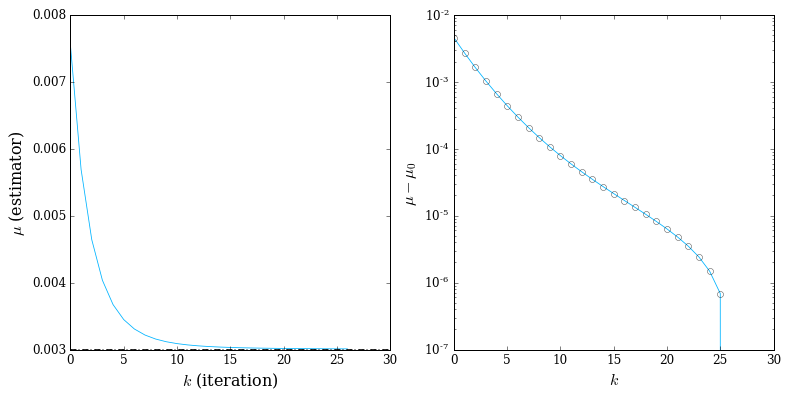

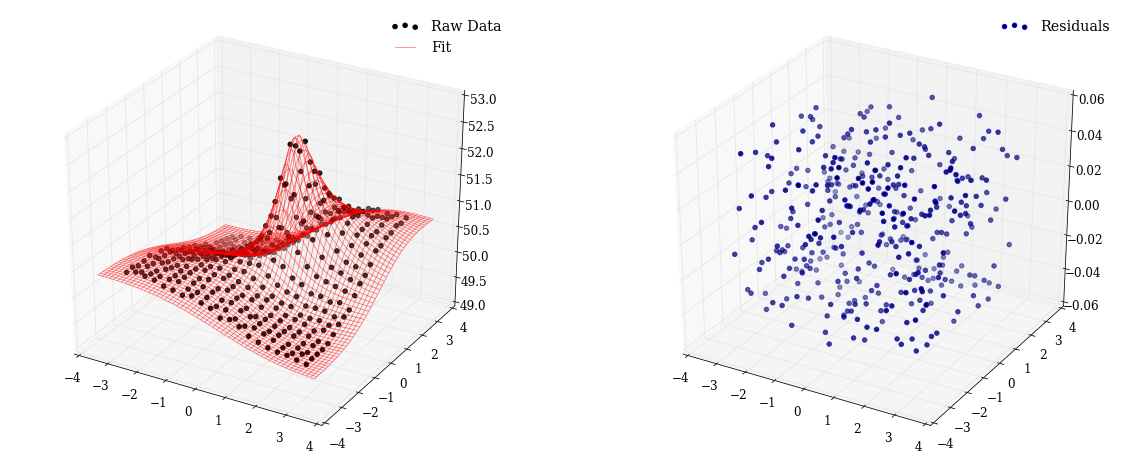

In [19]:
foo.plot()

### Generate python string for fit model

In [18]:
print foo.__str_python__(precision=8)

f = lambda x0,x1: 5.02906120e+01  +  5.36946527e-01 * (  5.40811124e-01*(x0) + -5.36549373e-01*(x0*x0) + 1.82491878e+00*(x0*x1) + 5.39374166e-01*(x1) + -5.38968316e-01*(x1*x1) + 1.30991035e+00 ) / ( 1.0 +  -1.00512289e+00*(x0) + 9.82611507e-01*(x0*x0) + -9.79243222e-01*(x1) + 9.84421650e-01*(x1*x1) )
